# Extracting regional values from Met Office Global meteorological data

## Process
This notebook runs you through how to extract spatial mean values from gridded data using shapefiles. The process includes:

1. Load the Shapefile for the regions we want to subset with.
2. Determine the full lat-lon extent of the shapefile.
3. Use lookup table shapefile_attributes.json to determine what geometry attributes we want to use for this shapefile.
4. Use daterange to generate filenames of NetCDFs we want to load
5. Load gridded data from NetCDF files into memory using Iris (using [lazy loading](https://scitools.org.uk/iris/docs/latest/userguide/real_and_lazy_data.html)).
6. Subset the data to only the extent of the shapefile, improving the processing time.
7. Define the functions to be used in the pipeline.
8. Loop through all the regions in the shapefile; subsetting, collapsing and generating a Pandas DataFrame for each region.
9. Each DataFrame is saved to CSV in a temporary location.
10. Collate all the region DataFrames into one DataFrame and save out to CSV
11. Delete the temporary files.

## Method
This process uses the polygon of a region (from the shapefile) to subset the gridded data by getting the **latitude-longitude bounding box** of the polygon, as described in this diagram:

<img src="images/coarse_spatial_mean_gridded.png" alt="Lat-Lon bounding box using polygon" style="height: 400px;"/> 

Each grid cell (small latitude-longitude box) contains a single value for a meteorological variable. The single value of that variable for the whole region/polygon is the mean of all the grid cell values in the bounding box i.e. lat-lon spatial mean.

For example, here we have air temperature values in a bounding box that covers the a polygon. The temperature value for the region is the mean value of the temperatures in the boundind box - 20.9°C.

<img src="images/spatial_mean_example.png" alt="The mean value for the temperature is 20.9°C" style="height: 400px;"/> 

#### Time
Of course we have ignored the time axis in this example, which is present in the gridded data but is handled for us by the Iris library as just another dimension. In this notebook we use daily data and will simply store the date for each value in the final tabular data.

#### Improvements
This process could be more accurate by only using the grid cells which actually overlap with the polygon and by weighting the grid cells according to how much of their area is within the polygon. Improvements like these are coming.

## Setup

In [4]:
#Data
import iris
import cartopy.io.shapereader as shpreader
import pandas as pd
import cftime
import datetime

#Plotting
import cartopy
import cartopy.crs as ccrs
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline

#System
import os
import sys
import glob
import json

#Met Office utils
import shape_utils as shape

#Supress warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Load shapefile containing region polygons

In [5]:
#Define shapefile path
SHAPEFILE = '../covid-19/it_shapefiles/gadm36_ITA_2.shp'

In [6]:
#Load the shapefile
shape_reader = shpreader.Reader(SHAPEFILE)

In [7]:
#How many regions are included?
len([record for record in shape_reader.records()])

110

In [8]:
#Let's take a look at one
next(shape_reader.records())

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f5ede045da0>, {'GID_0': 'ITA', 'NAME_0': 'Italy', 'GID_1': 'ITA.1_1', 'NAME_1': 'Abruzzo', 'NL_NAME_1': '', 'GID_2': 'ITA.1.1_1', 'NAME_2': 'Chieti', 'VARNAME_2': '', 'NL_NAME_2': '', 'TYPE_2': 'Provincia', 'ENGTYPE_2': 'Province', 'CC_2': '69', 'HASC_2': 'IT.CH'}, <fields>>

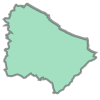

In [9]:
next(shape_reader.geometries())

## 2. Determine the full lat-lon extent of the shapefile

First we need some functions to help us

In [10]:
def get_shapefile_extent(shape_reader, buffer=0, **kwargs):
    '''
    Get the extent (x1, x2, y1, y2) of the union of all the polygons
    in a shapefile reader object, with an optional buffer added on.
    
    Arguments:
        shape_reader (cartopy.io.shapereader): Shapefile reader object
        buffer (num): optional buffer to add to the extent of the shapefile
        **kwargs: Keyword arguments for shape_utils.Shape class
    
    Returns:
        extent (tuple): Extent float values in format (x1, x2, y1, y2)
        
    TODO: Split into
            - get_shapefile_shapelist(shape_reader)
            - get_shapelist_union(shapelist, **kwargs)
            - get_shape_extent(shape, buffer=0)
    '''
    #Get all the records from shapefile_reader
    recs = [rec for rec in shape_reader.records()]
    
    #Cycle through all the records in recs,
    #appending Shape object to ShapeList, if shape is valid
    shplist = shape.ShapeList([])
    for rec in recs:
        shp = shape.Shape(rec.geometry, rec.attributes, **kwargs) 
        if shp.is_valid:
            shplist.append(shp)
    
    #Get extent of union of all geometries
    wsen = shplist.unary_union().data.bounds
    
    #Rearrange extent from (x1, y1, x2, y2) to (x1, x2, y1, y2), adding buffer
    extent = (wsen[0]-buffer, wsen[2]+buffer, wsen[1]-buffer, wsen[3]+buffer)
    
    return extent

In [11]:
def plot_extent(extent):
    '''
    Use Matplotlib to plot the given extent on a map of the world, 
    in Plate Carree projection, with coastlines and country boundaries.
    
    Arguments:
        extent (tuple): Float values for lat-lon coordinates in (x1, x2, y1, y2) format
    
    Returns: 
        Displays plot
    '''
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='b')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(extent)
    plt.show()

In [12]:
#Get the extent of the shapefile, with a buffer of 1 degree
SHAPE_EXTENT = get_shapefile_extent(shape_reader, buffer=1)
SHAPE_EXTENT

(5.63087893, 19.52069473, 34.49291611, 48.09096146)

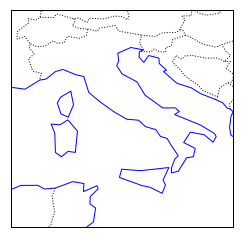

In [13]:
#Plot it onto a map of the world to check that it looks how we expect it to
plot_extent(SHAPE_EXTENT)

## 3. Use lookup table shapefile_attributes.json to determine what shapefile attributes we want to use later.

In [14]:
#Define json path
json_read = './shapefile_attributes.json'

In [15]:
#Get shapefile name
shape_name = SHAPEFILE.split('/')[-1].split('.')[-2]
shape_name

'gadm36_ITA_2'

In [16]:
#Load COLUMNS from json file as a tuple
with open(json_read) as file:
    COLUMNS = tuple(json.load(file)['shapefile_attributes'][shape_name])
    
COLUMNS

('GID_2', 'HASC_2', 'NAME_0', 'NAME_1', 'NAME_2', 'ENGTYPE_2')

In [17]:
#The first attribute in COLUMNS will be the shapefile attribute we iterate over in our pipeline
SHAPE_IDS = tuple(record.attributes[COLUMNS[0]] for record in shape_reader.records())
SHAPE_IDS[0:10]

('ITA.1.1_1',
 'ITA.1.2_1',
 'ITA.1.3_1',
 'ITA.1.4_1',
 'ITA.2.1_1',
 'ITA.2.2_1',
 'ITA.2.3_1',
 'ITA.2.4_1',
 'ITA.2.5_1',
 'ITA.2.6_1')

## 4. Use daterange to generate filenames of NetCDFs we want to load

In [18]:
#Define date range
start = datetime.date(2020, 3, 1)
stop = datetime.date(2020, 3, 11)
step = datetime.timedelta(days=1)
DATERANGE = pd.date_range(start, stop, freq=step)
DATERANGE

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11'],
              dtype='datetime64[ns]', freq='D')

In [19]:
filename_fmt = f'*_%Y%m%d.nc'
FILENAMES = list(DATERANGE.strftime(filename_fmt))
print(FILENAMES[0])
print(FILENAMES[-1])

*_20200301.nc
*_20200311.nc


## 5. Load gridded data from NetCDF files into memory using Iris (using [lazy loading](https://scitools.org.uk/iris/docs/latest/userguide/real_and_lazy_data.html)).

The files for each variable are contained in a separate folder.

In [20]:
%%time
#List all the filepaths and store in a dict with each variable as a key
folder = '/data/misc/covid-19/data_nc_daily/'
filepaths = {}
for path in os.listdir(folder):
    filepaths[path] = []
    for filename in FILENAMES:
        filepaths[path].extend(glob.glob(os.path.join(folder, path, filename)))
variables = list(filepaths.keys())

print(variables)
print(f'Number of files for each variable: {len(filepaths[variables[0]])}')

['precip_mean', 'sh_max', 'sh_min', 't1o5m_mean', 't1o5m_min', 'precip_max', 'sw_mean', 'sw_max', 't1o5m_max', 'sh_mean']
Number of files for each variable: 11
CPU times: user 67.3 ms, sys: 1.2 ms, total: 68.5 ms
Wall time: 5.74 s


In [21]:
%%time
#Run through all the variables and append the loaded cubes to a CubeList
cubes = iris.cube.CubeList([])

for var in variables:
    cubes.extend(iris.load(filepaths[var]))
    
print(cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 11; latitude: 1920; longitude: 2560)
1: specific_humidity / (1)             (time: 11; latitude: 1920; longitude: 2560)
2: specific_humidity / (1)             (time: 11; latitude: 1920; longitude: 2560)
3: air_temperature / (K)               (time: 11; latitude: 1920; longitude: 2560)
4: air_temperature / (K)               (time: 11; latitude: 1920; longitude: 2560)
5: precipitation_flux / (kg m-2 s-1)   (time: 11; latitude: 1920; longitude: 2560)
6: m01s01i202 / (1)                    (time: 11; latitude: 1920; longitude: 2560)
7: m01s01i202 / (1)                    (time: 11; latitude: 1920; longitude: 2560)
8: air_temperature / (K)               (time: 11; latitude: 1920; longitude: 2560)
9: specific_humidity / (1)             (time: 11; latitude: 1920; longitude: 2560)
CPU times: user 8.1 s, sys: 469 ms, total: 8.57 s
Wall time: 54.1 s


## 6. Subset global data based on the extent of the shapefile

In [22]:
#Define CoordExtent objects for x and y axes using SHAPE_EXTENT
x_axis = cubes[0].coord(axis='x')
y_axis = cubes[0].coord(axis='y')

x_extent = iris.coords.CoordExtent(x_axis, SHAPE_EXTENT[0], SHAPE_EXTENT[1])
y_extent = iris.coords.CoordExtent(y_axis, SHAPE_EXTENT[2], SHAPE_EXTENT[3])

In [23]:
#Subset cubes
shape_cubes = iris.cube.CubeList([cube.intersection(x_extent, y_extent) for cube in cubes])
print(shape_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 11; latitude: 145; longitude: 99)
1: specific_humidity / (1)             (time: 11; latitude: 145; longitude: 99)
2: specific_humidity / (1)             (time: 11; latitude: 145; longitude: 99)
3: air_temperature / (K)               (time: 11; latitude: 145; longitude: 99)
4: air_temperature / (K)               (time: 11; latitude: 145; longitude: 99)
5: precipitation_flux / (kg m-2 s-1)   (time: 11; latitude: 145; longitude: 99)
6: m01s01i202 / (1)                    (time: 11; latitude: 145; longitude: 99)
7: m01s01i202 / (1)                    (time: 11; latitude: 145; longitude: 99)
8: air_temperature / (K)               (time: 11; latitude: 145; longitude: 99)
9: specific_humidity / (1)             (time: 11; latitude: 145; longitude: 99)


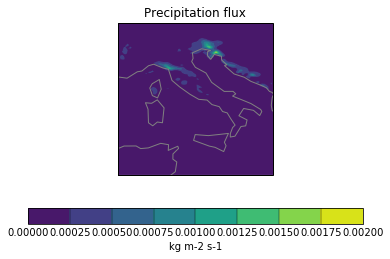

In [24]:
#Plot the first time step of the first cube in cubes
#To check that we've subsetted correctly
qplt.contourf(shape_cubes[0][0])
plt.gca().coastlines(color='grey')

In [25]:
#Extract the coordinate reference system from one of the cubes. We will use this later.
CRS = shape_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

## 7. Define the functions to be used in the pipeline.

### Shapefile functions

In [26]:
def get_shape_record(target, shape_reader=shape_reader, attribute=COLUMNS[0]):
    '''
    Get a record from the shape_reader with a target attribute.
    
    '''
    result = None
    for record in shape_reader.records():
        shape_id = record.attributes[attribute]
        if shape_id == target:
            result = record
            break
    if result is None:
        emsg = f'Could not find record with {attribute} = "{target}".'
        raise ValueError(emsg)
    return result

In [27]:
#Create a random ID generator
from random import randint
def rand_id(ids=SHAPE_IDS):
    '''
    Return a random id
    Useful for testing
    '''
    rand_i = randint(0, len(ids))
    return ids[rand_i]

ITA.6.5_1


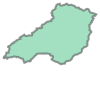

In [28]:
#Get a random geometry to check it's all working as expected
i = rand_id()
print(i)
get_shape_record(i).geometry

### Gridded data functions

In [43]:
def get_cell_method(cube, coord='time'):
    '''
    Get the cell method with coord in coord_names
    '''
    result = None
    for method in cube.cell_methods:
        if coord in method.coord_names:
            result = method.method
            break
    
    return result

In [41]:
def parse_data_name(cube):
    '''
    Parse the name, cell methods and units in a cube to return a column name
    To be used in a Pandas DataFrame
    '''
    name = cube.name()
    time_method = get_cell_method(cube, 'time').replace('imum', '')
    space_method = get_cell_method(cube, 'longitude')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        if space_method.startswith('var'):
            units = 'W2 m-4'
        else:
            units = 'W m-2'
    
    if space_method:
        result = f'{name}_{time_method}_{space_method.replace("imum", "")} ({units})'
    else:
        result = f'{name}_{time_method} ({units})'
    
    return result

In [31]:
def get_date(dt):
    '''
    Return date from datetime-like object dt
    '''
    return datetime.date(dt.year, dt.month, dt.day)

In [61]:
def get_column_order(start, mid, end):
    '''
    
    '''
    start_mid = tuple(start) + tuple(mid)
    
    ends = tuple(sorted([c for c in end if c not in start_mid]))
    
    start_mid_end = start_mid + ends
    
    return start_mid_end

In [68]:
def extract_collapse_df(shape_id, cubes=shape_cubes, **kwargs):
    '''
    Extract subcubes from cubes using geometry of shape_id
    Collapse the cube acros x and y coords to get the MEAN and VARIANCE
    Collect data in a dataframe for this shape_id
    
    Extract method:
        Extracts XY bounding box around geometry
        Refer to [Method](#Method) at top of this notebook for detailed description
        
    Arguments:
        shape_id (str): ID of geometry used for subsetting
        cubes (iris.CubeList): List of Iris cubes to be subsetted
        
    Returns: 
        df (pandas.DataFrame): DataFrame containing shape_id attributes 
                               and MEAN+VARIANCE of data in cubes for shape_id geometry
    '''
    #Create a Shape object from the record for shape_id
    region = get_shape_record(shape_id, **kwargs)
    shp = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    
    #Extract sub_cubes from cubes using shp
    sub_cubes = shp.extract_subcubes(cubes)
    
    #Collapse cubes across x and y coords with to get mean and variance
    mean_cubes = [cube.collapsed([cube.coord(axis='x'),cube.coord(axis='y')], iris.analysis.MEAN) for cube in sub_cubes]
    var_cubes = [cube.collapsed([cube.coord(axis='x'),cube.coord(axis='y')], iris.analysis.VARIANCE) for cube in sub_cubes]
    
    #Line up data and column names for Pandas DataFrame
    time = mean_cubes[0].coord('time')
    length = len(time.points)
    data = {name: [region.attributes[name]]*length for name in COLUMNS}
    data.update({'date': [get_date(cell.point) for cell in time.cells()]})
    data.update({parse_data_name(cube): cube.data for cube in mean_cubes})
    data.update({parse_data_name(cube): cube.data for cube in var_cubes})
    
    #Get a column order so that all dataframes have the same column order
    column_order = get_column_order(COLUMNS, ['date'], data.keys())
    
    #Create DataFrame
    df = pd.DataFrame(data, columns=column_order)

    return df

In [70]:
%%time
cblst = shape_cubes[0:2]
extract_collapse_df(rand_id(), cblst)

CPU times: user 911 ms, sys: 450 ms, total: 1.36 s
Wall time: 849 ms


,GID_2,HASC_2,NAME_0,NAME_1,NAME_2,ENGTYPE_2,date,precipitation_flux_mean_mean (kg m-2 s-1),precipitation_flux_mean_variance (m-4.kg2.s-2),specific_humidity_max_mean (1),specific_humidity_max_variance (1)
0,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-01,3.118868e-05,6.818400e-10,0.008735,3.270043e-07
1,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-02,1.355012e-04,1.137766e-08,0.008698,2.000180e-07
2,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-03,3.781772e-05,7.763896e-10,0.006115,1.772472e-07
3,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-04,1.373367e-05,1.770540e-10,0.006233,1.885285e-07
4,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-05,1.482610e-05,2.080587e-10,0.008783,2.274173e-07
5,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-06,2.205687e-05,3.954491e-10,0.007867,5.835428e-07
6,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-07,1.675616e-05,1.909096e-10,0.006113,2.197273e-07
7,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-08,7.783295e-07,1.908194e-11,0.006218,2.858033e-07
8,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-09,2.693499e-05,3.060873e-10,0.006962,2.162305e-07
9,ITA.14.4_1,IT.NR,Italy,Sardegna,Nuoro,Province,2020-03-10,3.240727e-06,3.549332e-11,0.006776,2.257219e-07


###

### 1. Load Met Office Global Data

## 4. Define the functions to be used in the pipeline.

In [ ]:
id_ = rand_id()
print(id_)
print(extract(id_, us_cubes, attribute='OBJECTID'))
display(get_shape_record(shape_reader, id_, 'OBJECTID').geometry)

In [ ]:
df_ex = extract_collapse_df(id_)
df_ex

## 5. Loop through all the regions in the shapefile; subsetting, collapsing and saving out to a CSV file for each region.

In [ ]:
#Set the order of the columns in the dataframes we will create
col0 = ['objectid', 'fips', 'county_name', 'state_name', 'date']
col1 = [parse_data_name(cube) for cube in us_cubes]
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

In [ ]:
#Let's look at the cubes we are going to 
print(us_cubes)

In [ ]:
#For now let's assume we haven't written any files, so we will loop through all the region IDs
unwritten = region_ids

In [ ]:
%%time
#This will loop through all the region IDs, executing extract_collapse_df for each region and saving it to a CSV file
#Any errors will be caught and printed, but the loop will continue onto the next ID
#Note that we cannot write to covid19-ancillary-data, so will have to write to /data/share/
start = len(csvs)
stop = len(region_ids)
for shape_id in unwritten[start:]:
    try:
        df = extract_collapse_df(shape_id)
        fname = df['fips'][0]
        county = df['county_name'][0]
        state = df['state_name'][0]
        df.to_csv(f'/data/share/us_data/us_{fname}_daily_data_2020jan-mar.csv', index=False)
        print(f'  [{shape_id}] {fname}, {county}, {state}: Success')
    except Exception as e:
        print(f'x [{shape_id}] {fname}, {county}, {state}: Error \n  x  {e}')

## 6. Load all the region CSVs, collate into one large DataFrame and save out to CSV.

In [ ]:
#List all the csvs in /data/share/us_data/
csvs = glob.glob('/data/share/us_data/*.csv')
len(csvs)

In [ ]:
%%time
#Now load all the CSVs for each region and combine into one large dataframe
df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
df

In [ ]:
#And save to a CSV
fname_write = '/data/share/us_daily_precipdata_2020jan-mar_v01.csv'
Mdf.to_csv(fname_write, index=False)

In [ ]:
#We can read it back in to check that it wrote correctly
pd.read_csv(fname_write)